In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p ./kaggle

In [4]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset
License(s): other
 97% 729M/750M [00:06<00:00, 115MB/s]
100% 750M/750M [00:06<00:00, 129MB/s]


In [5]:
!unzip /content/stanford-dogs-dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/Images/n02108089-boxer/n02108089_11687.jpg  
  inflating: /content/images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: /content/images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: /content/images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: /content/images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: /content/images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: /content/images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: /content/images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: /content/images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: /content/images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: /content/images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: /content/images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: /content/images/Images/n02108089-boxer/n02108089_1353.

In [34]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from glob import glob
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns
import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input

In [7]:
!python --version

Python 3.10.12


In [8]:
print(tf.__version__)

2.15.0


In [ ]:
# Define your project name
project_name = 'Stanford_Dogs_Detection'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Stanford dogs dataset Prediction'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Stanford dogs dataset Prediction/Stanford_Dogs_Detection


In [45]:
breed_list = os.listdir("/content/images/Images")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("/content/images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


In [47]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [73]:
breed_list[0]

'n02090622-borzoi'

In [56]:
label_maps_rev[12]

'n02090721-Irish_wolfhound'

In [11]:
import matplotlib.image as mpimg
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "/content/images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    # print("Images name", images)
    # print("Images length", len(images))

    for i in range(n_to_show):
        img = cv2.imread(os.path.join(img_dir, images[i]))
        plt.subplot(int(n_to_show/4), 4, i+1)
        plt.imshow(img)
    #     plt.axis('off')

In [12]:
print(breed_list[1])
show_dir_images(breed_list[1], 16)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# Define paths
base_dir = '/content/images/Images'
train_dir = '/content/train'
validation_dir = '/content/validation'
test_dir = '/content/test'

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to split data
def split_data(source_dir, train_dir, validation_dir, test_dir, train_split=0.7, validation_split=0.2):
    breeds = os.listdir(source_dir)
    for breed in breeds:
        breed_path = os.path.join(source_dir, breed)
        images = glob(os.path.join(breed_path, '*.jpg'))
        random.shuffle(images)
        train_size = int(train_split * len(images))
        validation_size = int(validation_split * len(images))

        train_images = images[:train_size]
        validation_images = images[train_size:train_size + validation_size]
        test_images = images[train_size + validation_size:]

        breed_train_dir = os.path.join(train_dir, breed)
        breed_validation_dir = os.path.join(validation_dir, breed)
        breed_test_dir = os.path.join(test_dir, breed)

        os.makedirs(breed_train_dir, exist_ok=True)
        os.makedirs(breed_validation_dir, exist_ok=True)
        os.makedirs(breed_test_dir, exist_ok=True)

        for image in train_images:
            shutil.copy(image, breed_train_dir)

        for image in validation_images:
            shutil.copy(image, breed_validation_dir)

        for image in test_images:
            shutil.copy(image, breed_test_dir)

# Split the data
split_data(base_dir, train_dir, validation_dir, test_dir)


In [52]:
breed_list = os.listdir("/content/train")

num_classes = len(breed_list)
print("No of breeds are {}".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("/content/train/{}".format(breed)))
print("Training Images Are {}".format(n_total_images))

No of breeds are 120
Training Images Are 14355


In [53]:
breed_list = os.listdir("/content/test")

num_classes = len(breed_list)
print("No of breeds are {}".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("/content/test/{}".format(breed)))
print("Test Images Are {}".format(n_total_images))

No of breeds are 120
Test Images Are 2153


In [54]:
breed_list = os.listdir("/content/validation")

num_classes = len(breed_list)
print("No of breeds are {}".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("/content/validation/{}".format(breed)))
print("Validation Images Are {}".format(n_total_images))

No of breeds are 120
Validation Images Are 4072


In [20]:
def count_files_in_subdirs(directory, set_name):
    counts = {}

    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'
validation_dir = '/content/validation'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

validation_count = count_files_in_subdirs(test_dir, 'validation')
print(validation_count)

       n02090622-borzoi  n02106030-collie  n02087394-Rhodesian_ridgeback  \
train               105               107                            120   

       n02111500-Great_Pyrenees  n02099849-Chesapeake_Bay_retriever  \
train                       149                                 116   

       n02110958-pug  n02093754-Border_terrier  n02108422-bull_mastiff  \
train            140                       120                     109   

       n02099712-Labrador_retriever  n02093991-Irish_terrier  ...  \
train                           119                      118  ...   

       n02096051-Airedale  n02086910-papillon  n02090379-redbone  \
train                 141                 137                103   

       n02091134-whippet  n02113799-standard_poodle  \
train                130                        111   

       n02113712-miniature_poodle  n02099601-golden_retriever  \
train                         108                         105   

       n02093859-Kerry_blue_terrier  

<Axes: >

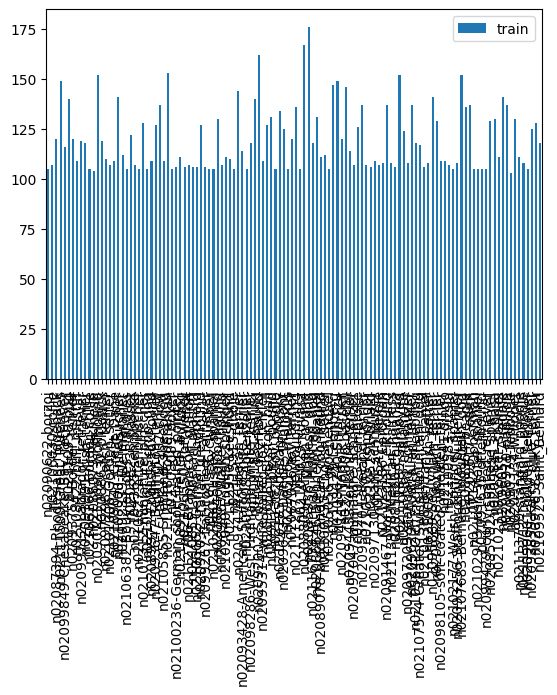

In [21]:
train_count.transpose().plot(kind='bar')

<Axes: >

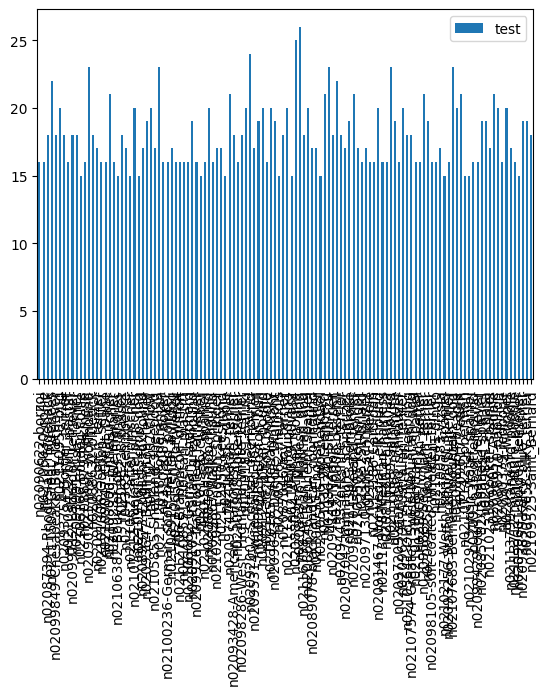

In [22]:
test_count.transpose().plot(kind='bar')

<Axes: >

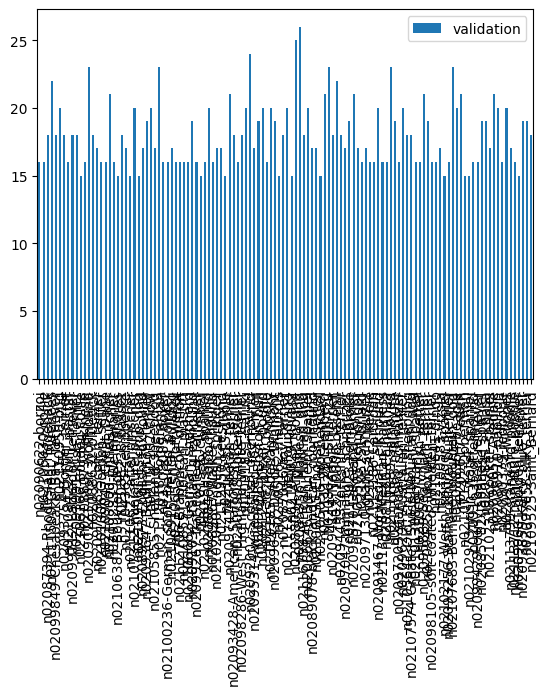

In [23]:
validation_count.transpose().plot(kind='bar')

In [24]:
image = '/content/train/n02085620-Chihuahua/n02085620_10131.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (495, 395, 3)


In [25]:
image = '/content/train/n02085620-Chihuahua/n02085620_11140.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (375, 500, 3)


In [26]:
# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [27]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # ResNet50 expects 224x224 images
    batch_size=32,
    class_mode='categorical'
)

Found 14355 images belonging to 120 classes.


In [28]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 4072 images belonging to 120 classes.


In [29]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2153 images belonging to 120 classes.


In [ ]:
# Load the DenseNet121 Model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the Base Model Layers
for layer in base_model.layers[:-6]:
    layer.trainable = False

# Add Custom Layers on Top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(120, activation='softmax')(x)  # 120 classes for 120 dog breeds

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [57]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Stanford dogs dataset Prediction/Stanford_Dogs_Detection'
name = 'DenseNet121.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Stanford dogs dataset Prediction/Stanford_Dogs_Detection/DenseNet121.keras'

In [58]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [59]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [60]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop]  # Adjusted as per your use-case

In [ ]:
# Compile the Model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=100,
    callbacks=callbacks
)


Epoch 1/100
448/448 [==============================] - ETA: 0s - loss: 3.0608 - accuracy: 0.2531
Epoch 1: val_loss improved from inf to 1.32548, saving model to /content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Stanford dogs dataset Prediction/Stanford_Dogs_Detection/DenseNet121.keras
448/448 [==============================] - 78s 147ms/step - loss: 3.0608 - accuracy: 0.2531 - val_loss: 1.3255 - val_accuracy: 0.6029
Epoch 2/100
448/448 [==============================] - ETA: 0s - loss: 1.7808 - accuracy: 0.4907
Epoch 2: val_loss improved from 1.32548 to 1.06483, saving model to /content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Stanford dogs dataset Prediction/Stanford_Dogs_Detection/DenseNet121.keras
448/448 [==============================] - 61s 135ms/step - loss: 1.7808 - accuracy: 0.4907 - val_loss: 1.0648 - val_accuracy: 0.6826
Epoch 3/100
448/448 [==============================] - ETA: 0s - loss: 1.5256 - accuracy: 0.5506
Epoch 3: val_loss improved from 1.06483 to 1.00930, sav

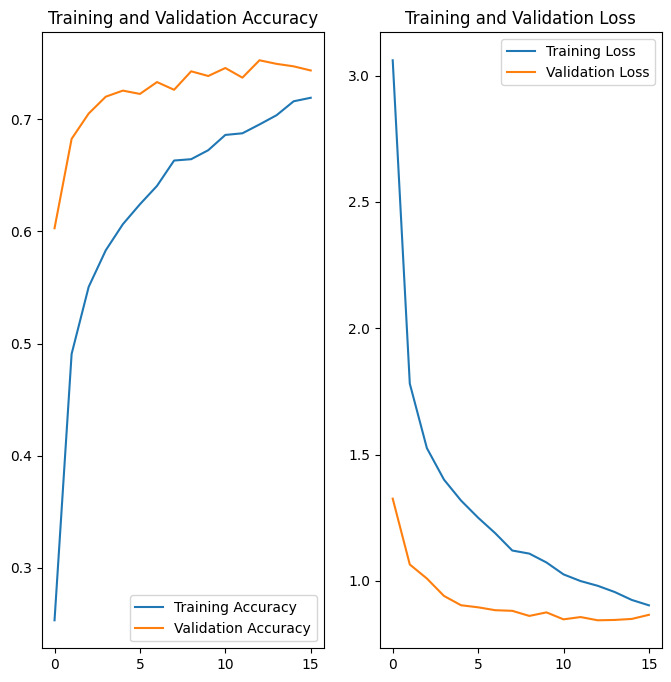

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

68/68 [==============================] - 11s 163ms/step - loss: 0.8526 - accuracy: 0.7427
final train accuracy = 85.66 , validation accuracy = 74.27


In [30]:
cnn_path = '/content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Stanford dogs dataset Prediction/Stanford_Dogs_Detection'
name = 'DenseNet121.keras'
chk_path = os.path.join(cnn_path, name)
# Check if the checkpoint file exists
if os.path.exists(chk_path):
    print("Loading model from checkpoint...")
    best_model = load_model(chk_path)

Loading model from checkpoint...


In [63]:
# Compile the Model
best_model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [65]:
history2 = best_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
448/448 [==============================] - ETA: 0s - loss: 0.9870 - accuracy: 0.7012
Epoch 1: val_loss did not improve from 0.62368
448/448 [==============================] - 71s 158ms/step - loss: 0.9870 - accuracy: 0.7012 - val_loss: 0.6332 - val_accuracy: 0.8108
Epoch 2/20
448/448 [==============================] - ETA: 0s - loss: 0.9657 - accuracy: 0.7057
Epoch 2: val_loss did not improve from 0.62368
448/448 [==============================] - 61s 135ms/step - loss: 0.9657 - accuracy: 0.7057 - val_loss: 0.6507 - val_accuracy: 0.7933
Epoch 3/20
448/448 [==============================] - ETA: 0s - loss: 0.9431 - accuracy: 0.7107
Epoch 3: val_loss did not improve from 0.62368
448/448 [==============================] - 61s 135ms/step - loss: 0.9431 - accuracy: 0.7107 - val_loss: 0.6692 - val_accuracy: 0.7921
Epoch 4/20
448/448 [==============================] - ETA: 0s - loss: 0.9458 - accuracy: 0.7132
Epoch 4: val_loss did not improve from 0.62368
Restoring model weights fr

In [66]:
train_loss, train_accu = best_model.evaluate(train_generator)
test_loss, test_accu = best_model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

68/68 [==============================] - 7s 108ms/step - loss: 0.6272 - accuracy: 0.8007
final train accuracy = 85.01 , validation accuracy = 80.07


In [69]:
class_indices = train_generator.class_indices


In [70]:
class_names = {v: k for k, v in class_indices.items()}


In [110]:
import json

In [111]:
with open('/content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Stanford dogs dataset Prediction/Stanford_Dogs_Detection/class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)


In [112]:
with open('/content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Stanford dogs dataset Prediction/Stanford_Dogs_Detection/class_indices.json', 'r') as f:
    class_indices = json.load(f)
class_names = {v: k for k, v in class_indices.items()}


In [113]:
class_names[0]

'n02085620-Chihuahua'

In [72]:
class_names[0]

'n02085620-Chihuahua'

In [94]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Assuming the model was trained with images rescaled to [0, 1]
    return img_array


In [95]:
def predict_image(model, img_array):
    prediction = model.predict(img_array)
    return prediction


In [96]:
def decode_prediction(prediction, class_names):
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name


In [97]:
def predict_breed(img_path, model, class_names, target_size=(224, 224)):
    img_array = load_and_preprocess_image(img_path, target_size)
    prediction = predict_image(model, img_array)
    predicted_breed = decode_prediction(prediction, class_names)
    return predicted_breed


In [108]:
# Example image path
img_path = r"/content/test/n02085782-Japanese_spaniel/n02085782_2014.jpg"

# Predict breed
predicted_breed = predict_breed(img_path, best_model, class_names)
print(f'The predicted breed is: {predicted_breed}')

1/1 [==============================] - 0s 40ms/step
The predicted breed is: n02085782-Japanese_spaniel


In [109]:
# Define the path
save_path = '/content/drive/MyDrive/Hands-ON-Deep-Learningg-2024/Stanford dogs dataset Prediction/Stanford_Dogs_Detection/Best_DenseNet121.h5'

# Save the model
best_model.save(save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
